In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import scipy

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:

# Cleaning data functions according to rhe desired data
def clean_merged_data(merged_data):
    relevant_data = pd.DataFrame(index=merged_data.index)
    relevant_data["country"] = merged_data["country"]
    relevant_data["patience"] = merged_data["patience"]
    relevant_data["risktaking"] = merged_data["risktaking"]
    relevant_data["posrecip"] = merged_data["posrecip"]
    relevant_data["negrecip"] = merged_data["negrecip"]
    relevant_data["altruism"] = merged_data["altruism"]
    relevant_data["trust"] = merged_data["trust"]
    relevant_data["wgt_x"] = merged_data["wgt_x"]

    return relevant_data


In [3]:

def clean_merged_data_gender(merged_data, gender):
    relevant_data = pd.DataFrame(index=merged_data.index)
    relevant_data["country"] = merged_data["country"]
    relevant_data["patience"] = merged_data["patience"]
    relevant_data["risktaking"] = merged_data["risktaking"]
    relevant_data["posrecip"] = merged_data["posrecip"]
    relevant_data["negrecip"] = merged_data["negrecip"]
    relevant_data["altruism"] = merged_data["altruism"]
    relevant_data["trust"] = merged_data["trust"]
    relevant_data["gender"] = merged_data["gender"]
    relevant_data = relevant_data[relevant_data["gender"] == gender]

    return relevant_data


In [4]:

def clean_merged_data_region(merged_data,region):
    relevant_data = pd.DataFrame(index=merged_data.index)
    relevant_data["country"] = merged_data["country"]
    relevant_data["patience"] = merged_data["patience"]
    relevant_data["risktaking"] = merged_data["risktaking"]
    relevant_data["posrecip"] = merged_data["posrecip"]
    relevant_data["negrecip"] = merged_data["negrecip"]
    relevant_data["altruism"] = merged_data["altruism"]
    relevant_data["trust"] = merged_data["trust"]

    relevant_data = relevant_data[relevant_data["country"].isin(region)]
    
    return relevant_data


In [5]:
# Generates preference measure by country (full data)
def preference_measure_1000(data, preference):
    df = pd.DataFrame(data.groupby("country")[preference].mean())
    '''
    df = pd.DataFrame()
    for pref in preference:
        df[pref] = data.dropna(subset=[pref, 'wgt_x']).groupby('country').apply(lambda x: np.average(x[pref], weights=x['wgt_x']))
    '''
    return df

In [6]:
# Generates preference measure by country (fraction of the data)
def generate_pref_measure_sample(data):
    preference_measure_sample = pd.DataFrame(data.reset_index().rename(columns={'index': 'country'}).groupby(['country']).mean())
    '''
    preference_measure_sample = pd.DataFrame()
    for pref in preference:
        preference_measure_sample[pref] = data.dropna(subset=[pref, 'wgt_x']).reset_index().rename(columns={'index': 'country'}).groupby(['country']).apply(lambda x: np.average(x[pref], weights=x['wgt_x']))
    '''
    return preference_measure_sample

In [7]:
# Random sampling a fraction of the full data
def random_sampling_pref(data, preference, num_iterations, fraction):
   
    # Initialize an empty DataFrame to store the results
    df = pd.DataFrame()   
    sampled_data = pd.DataFrame()
   
    # Repeat the sampling process for a specified number of iterations
    for i in range(num_iterations):
        # Group by 'country' and sample a fraction of the observations with replacement
        sampled_data = data.groupby("country")[preference].apply(lambda x: x.sample(frac=fraction, replace=True)).reset_index(level=1,drop=True)
        sampled_data.name = f"{preference}_{i+1}"
      
        # Concatenate the sampled data to the result DataFrame
        df = pd.concat([df, sampled_data], axis=1)
    return df

In [8]:
# Computes the correlation between the sampled preference measure
def preferences_measure(relevant, pref, iterations, fraction):

    # compute preference measure for 1000 obs by country
    pref_measure_1000 = preference_measure_1000(relevant, pref)
    pref_measure_1000
    
    # Generate n=len(iterations) samples for a fraction of the population
    pref_samples = random_sampling_pref(relevant,preference=pref, num_iterations=iterations, fraction=fraction)
    pref_samples
    
    pref_measure_samples = generate_pref_measure_sample(pref_samples)
    pref_measure_samples

    # CORRELATIONS
    corrrelation_1000_sample_measure = pref_measure_samples.corr().stack().tolist()
    corrrelation_1000_sample_measure = [corrrelation_1000_sample_measure[i] for i in range(len(corrrelation_1000_sample_measure)) if i % (iterations + 1) != 0]
    corrrelation_1000_sample_measure

    return corrrelation_1000_sample_measure

In [9]:
# Computes the correlation between the sampled preference ranks
def preferences_rank(relevant, pref, iterations, fraction):

    # compute preference measure for 1000 obs by country
    pref_measure_1000 = preference_measure_1000(relevant, pref)
    pref_measure_1000
    
    # compute preference rank for 1000 obs by country
    pref_rank_1000 = pref_measure_1000.rank(ascending=False, method='min')
    pref_rank_1000 = pref_rank_1000.round().astype(pd.Int8Dtype())
    pref_rank_1000

    # Generate n=len(iterations) samples for a fraction of the population
    pref_samples = random_sampling_pref(relevant,preference=pref, num_iterations=iterations, fraction=fraction)
    pref_samples

    pref_measure_samples = generate_pref_measure_sample(pref_samples)
    pref_measure_samples

    pref_rank_samples = pd.DataFrame()  
    for i in pref_measure_samples.columns:
        pref_rank_samples[i] = pref_measure_samples[i].rank(ascending=False, method='min')
        pref_rank_samples[i] = pref_rank_samples[i].round().astype(pd.Int8Dtype())
    pref_rank_samples

    # CORRELATIONS
    corrrelation_1000_sample_rank = pref_rank_samples.corr(method="spearman").stack().tolist()
    corrrelation_1000_sample_rank = [corrrelation_1000_sample_rank[i] for i in range(len(corrrelation_1000_sample_rank)) if i % (iterations + 1) != 0]
    corrrelation_1000_sample_rank

    return corrrelation_1000_sample_rank

Main

In [10]:
# Get data paths
this_path = Path(".")
directory_path = this_path.parent/"data_clean"/"merged_gps_gallup.csv"
directory_path_staircase = this_path.parent/"data_clean"/"staircase_patience.dta"

# Load merged data and select only relevant data ["country", "patience", "risktaking", "posrecip", "negrecip", "altruism", "trust", "wgt_x"]
merged_data = pd.read_csv(directory_path)
relevant_data = clean_merged_data(merged_data)

preferences = ["patience", "risktaking", "posrecip", "negrecip", "altruism", "trust"]


C:\Users\willi\AppData\Local\Temp\ipykernel_5188\101640640.py:7: DtypeWarning: Columns (16,63,66,68,69,71,72,75,79,80,81,82,83,84,86,88,90,91,94,96,97,99,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,120,121,125,126,129,131,137,138,139,142,144,147,148,149,154,159,163,165,166,168,170,171,173,174,175,178,184,186,187,188,189,190,191,192,193,194,195,198,200,201,202,203,204,205,206,208,209,210,211,213,214,215,216,218,221,222,224,226,231,232,233,237,239,240,241,242,245,246,247,248,252,254,256,260,261,262,263,265,267,268,272,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,354,355,356,357,359,366,368,370,371,372,373,374,375,377,378,379,380,381,382,383,384,386,387,389,395,396,397,398,399,400,401,406,407,413,414,415,416,417,418,419,420,421,422,423,42

In [11]:
# Rank correlations by gender (iterations = 100, fraction = 0.2 (per gender, roughly 100 observations per country))

relevant_data_female = clean_merged_data_gender(merged_data, 1) # 1 = female
relevant_data_male = clean_merged_data_gender(merged_data, 0) # 0 = male

for pref in preferences:
    # Construct the variable name dynamically
    variable_name = f"{pref}_rank_female"

    # Call the preferences_measure function with the dynamic variable name
    globals()[variable_name] = preferences_rank(relevant_data_female, pref=pref, iterations=1000, fraction=0.25)

for pref in preferences:
    # Construct the variable name dynamically
    variable_name = f"{pref}_rank_male"

    # Call the preferences_measure function with the dynamic variable name
    globals()[variable_name] = preferences_rank(relevant_data_male, pref=pref, iterations=1000, fraction=0.25)

# for loop to generate correlation values for each preference (rank) - fraction = 0.125
for pref in preferences:
    # Construct the variable name dynamically
    variable_name = f"{pref}_rank_125"

    # Call the preferences_measure function with the dynamic variable name
    globals()[variable_name] = preferences_rank(relevant_data, pref=pref, iterations=1000, fraction=0.125)

# Plot rank correlations by gender (iterations = 100, fraction = 0.2)


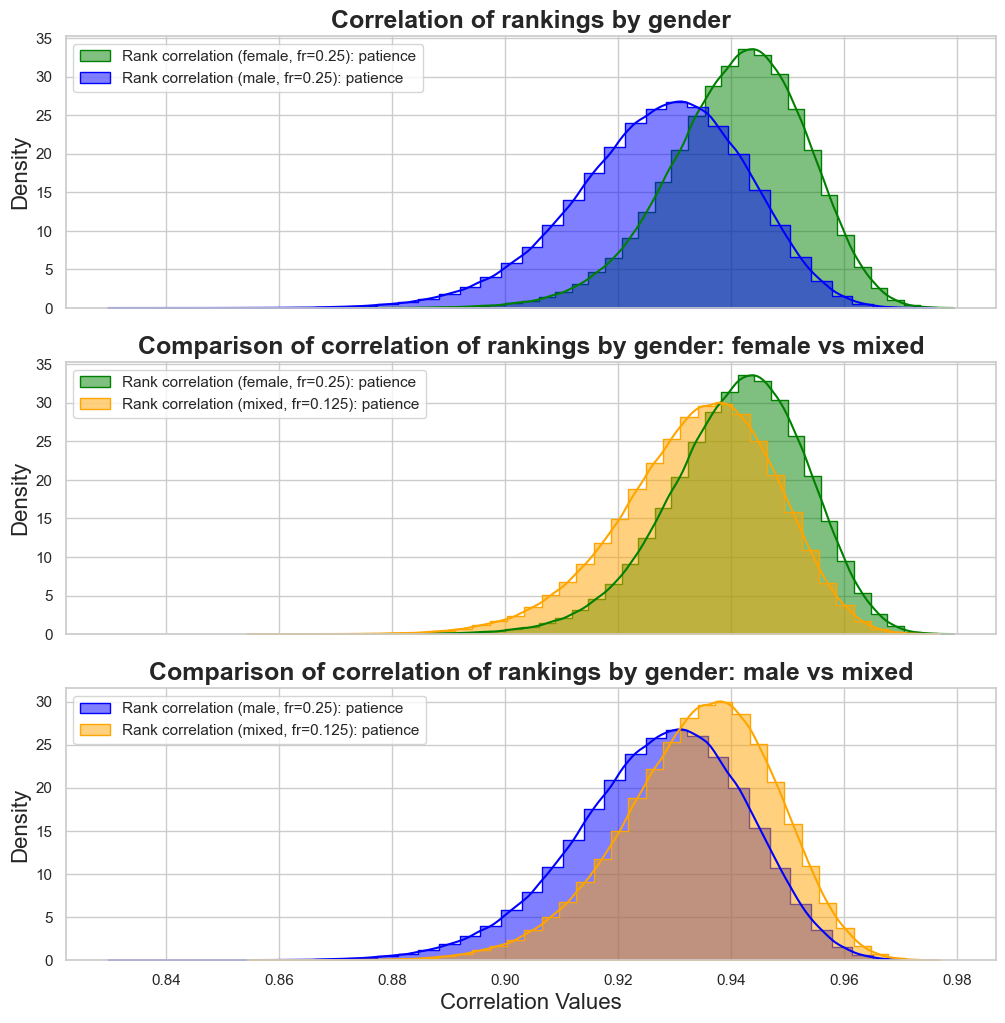

In [12]:
# Plot rank correlations by gender (iterations = 100, fraction = 0.2)

# Create subplots with 3 rows and 1 column
from tkinter import font


sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, pref in enumerate(preferences):
    # If the current preference is not "patience", skip to the next iteration
    if pref != "patience":
        continue

    # Construct the variable names dynamically
    rank_name_female = f"{pref}_rank_female"
    rank_name_male = f"{pref}_rank_male"
    rank_name_125 = f"{pref}_rank_125"
    

    
    # Plotting the histograms
    

    sns.histplot(globals()[rank_name_female], bins=40, color='green', kde=True, label=f'Rank correlation (female, fr=0.25): {pref}', element='step', stat='density', ax=axes[0])
    sns.histplot(globals()[rank_name_male], bins=40, color='blue', kde=True, label=f'Rank correlation (male, fr=0.25): {pref}', element='step', stat='density', ax=axes[0])
    axes[0].set_ylabel('Density', fontsize=16)
    axes[0].set_title(f'Correlation of rankings by gender', fontsize=18, fontweight='bold')
    axes[0].legend()

    sns.histplot(globals()[rank_name_female], bins=40, color='green', kde=True, label=f'Rank correlation (female, fr=0.25): {pref}', element='step', stat='density', ax=axes[1])
    sns.histplot(globals()[rank_name_125], bins=40, color='orange', kde=True, label=f'Rank correlation (mixed, fr=0.125): {pref}', element='step', stat='density', ax=axes[1])
    axes[1].set_ylabel('Density', fontsize=16)
    axes[1].set_title(f'Comparison of correlation of rankings by gender: female vs mixed', fontsize=18, fontweight='bold')
    axes[1].legend()

    sns.histplot(globals()[rank_name_male], bins=40, color='blue', kde=True, label=f'Rank correlation (male, fr=0.25): {pref}', element='step', stat='density', ax=axes[2])
    sns.histplot(globals()[rank_name_125], bins=40, color='orange', kde=True, label=f'Rank correlation (mixed, fr=0.125): {pref}', element='step', stat='density', ax=axes[2])
    axes[2].set_ylabel('Density', fontsize=16)
    axes[2].set_title(f'Comparison of correlation of rankings by gender: male vs mixed', fontsize=18, fontweight='bold')
    axes[2].legend()

# Set x-axis label for the last subplot
axes[-1].set_xlabel('Correlation Values', fontsize=16)

# Save the combined plot as an image
# plt.savefig(this_path.parent/"plots"/"sampling_by_gender_distribution.png")

# Display the plot
plt.show()